## 关于数据集 | About Dataset

### 内容 | Content

该数据集包含世界各地不同气象站每日记录的天气状况信息。信息包括降水量、降雪量、气温、风速，以及当天是否有雷暴或其他恶劣天气状况。

The dataset contains information on weather conditions recorded on each day at various weather stations around the world. Information includes precipitation, snowfall, temperatures, wind speed and whether the day included thunder storms or other poor weather conditions.


### 说明 | Description

- STA
  - 气象站 | Weather Station
- Date
- Precip
  - 降水量（毫米）| Precipitation (mm)
- MaxTemp
  - 最高温度（摄氏度）| Maximum temperature in degrees Celsius
  - -33.3 —— 50
- MinTemp
  - 最低温度（摄氏度）| Minimum temperature in degrees Celsius
  - -38.3 —— 34
- MeanTemp
  - 平均温度（摄氏度）| Mean temperature in degrees Celsius
- Snowfall
  - 降雪量（毫米）
- YR
  - 观测年份
- MO
  - 观测月份
- DA
  - 观测日
- MAX
  - 最高温度（华氏度）| Maximum temperature in degrees Fahrenheit
  - -28 —— 122
- MIN
  - 最低温度（华氏度）| Minimum temperature in degrees Fahrenheit
  - -37 —— 94
- MEAN
  - 平均温度（华氏度）| Mean temperature in degrees Fahrenheit
  - -32 —— 104

剩余的源数据列是缺失的，基本上可用的数据列只有以上列出的 | The remaining source data columns are missing, and basically, the only available data columns are those listed above.


---

这个项目来自 | This project is from 

https://www.kaggle.com/datasets/smid80/weatherww2/data?select = Summary+of+Weather.csv

---

## 复现

---

### 数据准备 | Data Preparation

---

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")


In [4]:
df = pd.read_csv("SummaryOfWeather.csv")


In [5]:
df.head().style.background_gradient(cmap = "viridis").hide(axis = "index")


STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,MO,DA,PRCP,DR,SPD,MAX,MIN,MEA,SNF,SND,FT,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
10001,1942-7-1,1.016,nan,25.555556,22.222222,23.888889,0.000000,nan,42,7,1,0.04,nan,nan,78.000000,72.000000,75.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-2,0,nan,28.888889,21.666667,25.555556,0.000000,nan,42,7,2,0,nan,nan,84.000000,71.000000,78.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-3,2.54,nan,26.111111,22.222222,24.444444,0.000000,nan,42,7,3,0.1,nan,nan,79.000000,72.000000,76.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-4,2.54,nan,26.666667,22.222222,24.444444,0.000000,nan,42,7,4,0.1,nan,nan,80.000000,72.000000,76.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
10001,1942-7-5,0,nan,26.666667,21.666667,24.444444,0.000000,nan,42,7,5,0,nan,nan,80.000000,71.000000,76.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   WindGustSpd  532 non-null     float64
 4   MaxTemp      119040 non-null  float64
 5   MinTemp      119040 non-null  float64
 6   MeanTemp     119040 non-null  float64
 7   Snowfall     117877 non-null  object 
 8   PoorWeather  34237 non-null   object 
 9   YR           119040 non-null  int64  
 10  MO           119040 non-null  int64  
 11  DA           119040 non-null  int64  
 12  PRCP         117108 non-null  object 
 13  DR           533 non-null     float64
 14  SPD          532 non-null     float64
 15  MAX          118566 non-null  float64
 16  MIN          118572 non-null  float64
 17  MEA          118542 non-null  float64
 18  SNF          117877 non-

In [7]:
def Missing_Values_Analysis(df):
    # Calculate missing values
    missing_data = df.isnull().sum()
    missing_df = pd.DataFrame({
        "Column": missing_data.index,
        "Missing_Count": missing_data.values,
        "Missing_Percentage": (missing_data.values / len(df) * 100).round(2)
    })

    # Create missing values visualization
    plt.figure(figsize = (12, 6))
    bars = plt.bar(missing_df["Column"], missing_df["Missing_Percentage"], 
                color = ["#ff0000" if p > 50 else "#009b49" if p > 10 else "#0082ff" for p in missing_df["Missing_Percentage"]])

    # Add value labels
    for bar, count in zip(bars, missing_df["Missing_Count"]):
        if count > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f"{count}", ha = "center", va = "bottom", fontsize = 8)

    # Set chart properties
    plt.title("Missing Values Analysis", fontsize = 14, fontweight = "bold")
    plt.xlabel("Columns")
    plt.ylabel("Missing Percentage (%)")
    plt.xticks(rotation = 45, ha = "right")
    plt.grid(axis = "y", alpha = 0.3)

    # Add legend
    legend_elements  =  [
        Patch(facecolor = "#0082ff", label = "Low Missing (<10%)"),
        Patch(facecolor = "#009b49", label = "Medium Missing (10-50%)"),
        Patch(facecolor = "#ff0000", label = "High Missing (>50%)")
    ]
    plt.legend(handles = legend_elements, loc = "upper left")

    plt.tight_layout()
    plt.show()

    # Display missing values statistics
    print("Missing Values Statistics:")
    print(missing_df.sort_values("Missing_Percentage", ascending = False))
    

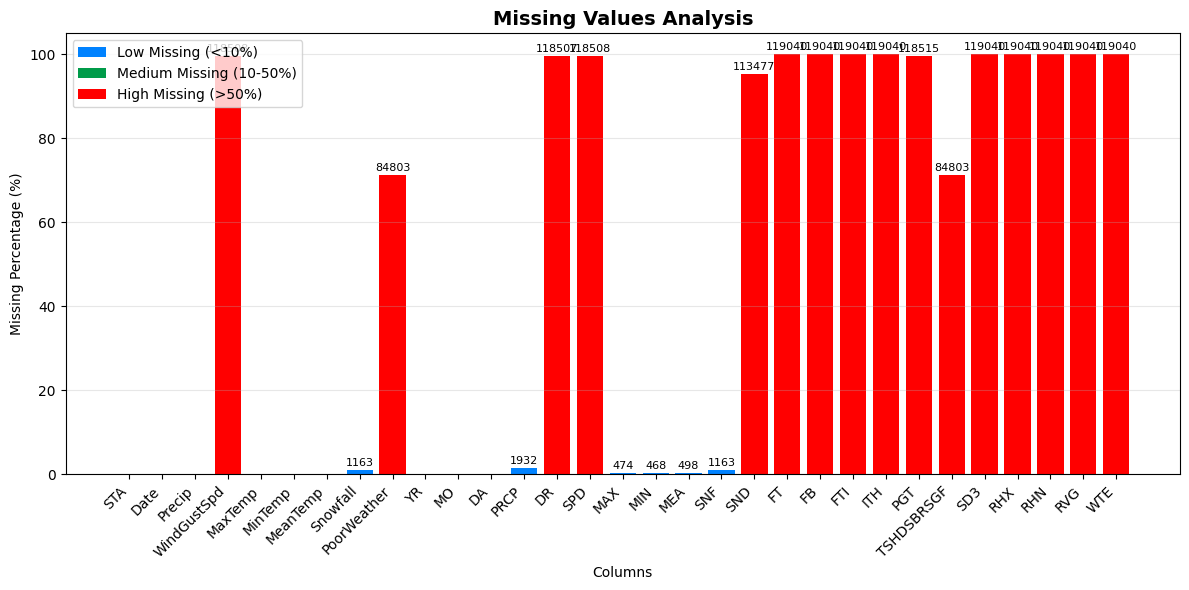

Missing Values Statistics:
         Column  Missing_Count  Missing_Percentage
26          SD3         119040              100.00
28          RHN         119040              100.00
27          RHX         119040              100.00
29          RVG         119040              100.00
20           FT         119040              100.00
22          FTI         119040              100.00
30          WTE         119040              100.00
23          ITH         119040              100.00
21           FB         119040              100.00
24          PGT         118515               99.56
3   WindGustSpd         118508               99.55
14          SPD         118508               99.55
13           DR         118507               99.55
19          SND         113477               95.33
8   PoorWeather          84803               71.24
25   TSHDSBRSGF          84803               71.24
12         PRCP           1932                1.62
18          SNF           1163                0.98
7   

In [8]:
Missing_Values_Analysis(df)


In [9]:
df = df[["MaxTemp", "MinTemp"]]


In [10]:
df.head().style.background_gradient(cmap = "viridis").hide(axis = "index")


MaxTemp,MinTemp
25.555556,22.222222
28.888889,21.666667
26.111111,22.222222
26.666667,22.222222
26.666667,21.666667


--- 

### 数据探索 | Data Exploration

---

In [11]:
def Data_Overview(df):
    # Simple data overview
    print("======================== DATASET OVERVIEW ==========================")
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep = True).sum() / 1024 ** 2:.2f} MB")

    print("\n======================== DATA TYPES ==========================")
    print(df.dtypes)

    print("\n======================== MISSING VALUES ==========================")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\n======================== NUMERICAL SUMMARY ==========================")
    print(df.describe())

    print("\n======================== ADDITIONAL MEASURES ==========================")
    print(f"Skewness: {df.skew().to_dict()}")
    print(f"Kurtosis: {df.kurtosis().to_dict()}")

    print("\n======================== FIRST FEW ROWS ==========================")
    print(df.head())
    

In [12]:
Data_Overview(df)


======================== DATASET OVERVIEW ==========================
Shape: (119040, 2)
Memory usage: 1.82 MB

======================== DATA TYPES ==========================
MaxTemp    float64
MinTemp    float64
dtype: object

======================== MISSING VALUES ==========================
Series([], dtype: int64)

======================== NUMERICAL SUMMARY ==========================
             MaxTemp        MinTemp
count  119040.000000  119040.000000
mean       27.045111      17.789511
std         8.717817       8.334572
min       -33.333333     -38.333333
25%        25.555556      15.000000
50%        29.444444      21.111111
75%        31.666667      23.333333
max        50.000000      34.444444

======================== ADDITIONAL MEASURES ==========================
Skewness: {'MaxTemp': -2.0806436434081648, 'MinTemp': -1.889983817822945}
Kurtosis: {'MaxTemp': 6.330237648548216, 'MinTemp': 4.517975063494198}

======================== FIRST FEW ROWS ==========================


In [13]:
def Plot_Visualization(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    
    # MaxTemp with viridis
    counts1, bins1, patches1 = ax1.hist(df["MaxTemp"].dropna(), bins = 50, alpha = 0.8, edgecolor = "black")
    for patch, color in zip(patches1, plt.cm.plasma(np.linspace(0, 1, len(patches1)))):
        patch.set_facecolor(color)
    
    # MinTemp with plasma
    counts2, bins2, patches2 = ax2.hist(df["MinTemp"].dropna(), bins = 50, alpha = 0.8, edgecolor = "black")
    for patch, color in zip(patches2, plt.cm.viridis(np.linspace(0, 1, len(patches2)))):
        patch.set_facecolor(color)
    
    # Set titles and labels
    for ax, title, temp_col in [(ax1, "MaxTemp", "MaxTemp"), (ax2, "MinTemp", "MinTemp")]:
        ax.set_title(f"Frequency Distribution - {title}")
        ax.set_xlabel(f"{title} (°C)")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)
    
    # Add colorbars
    plt.colorbar(plt.cm.ScalarMappable(
        cmap = plt.cm.plasma, 
        norm = plt.Normalize(vmin = df["MaxTemp"].min(), vmax = df["MaxTemp"].max())
        ), 
        ax=ax1, 
        shrink=0.8, 
        label="MaxTemp (°C)"
    )
    plt.colorbar(plt.cm.ScalarMappable(
        cmap = plt.cm.viridis, 
        norm = plt.Normalize(vmin = df["MinTemp"].min(), vmax = df["MinTemp"].max())
        ), 
        ax = ax2, 
        shrink = 0.8, 
        label = "MinTemp (°C)"
    )
    
    plt.tight_layout()
    plt.show()


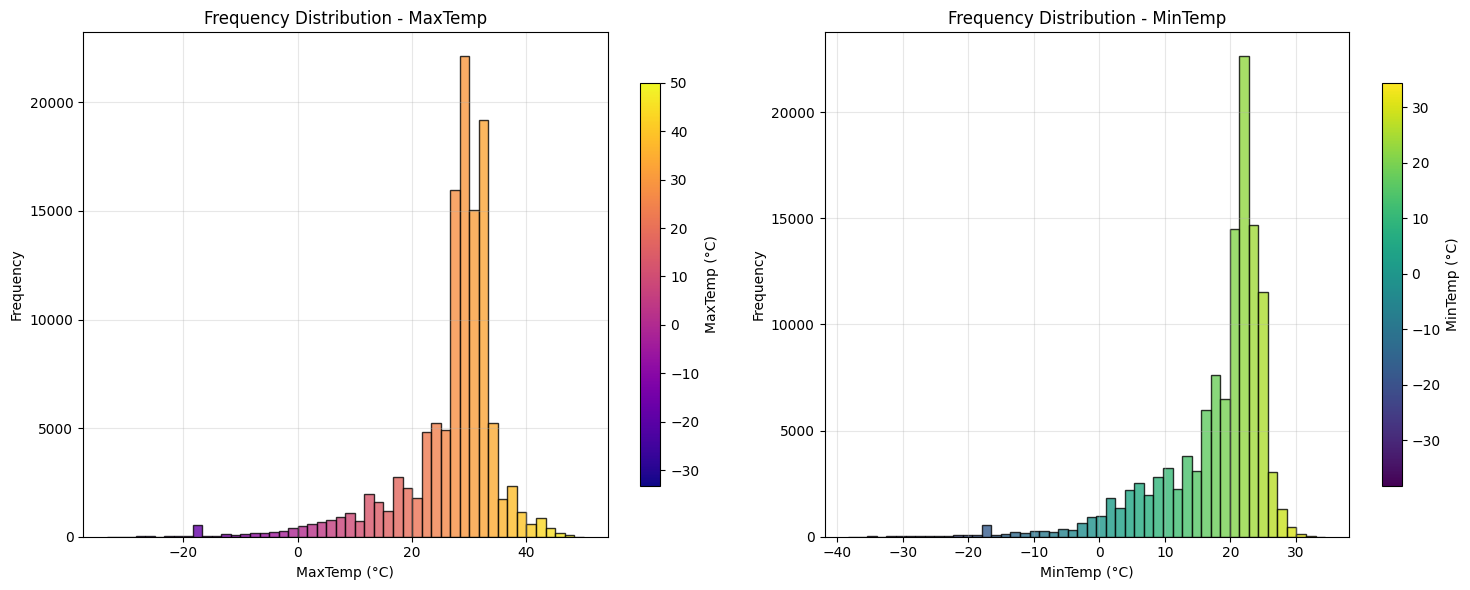

In [14]:
Plot_Visualization(df)


In [15]:
def Plot_Distribution(df):
    
    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(
        df["MinTemp"], df["MaxTemp"], c = df["MinTemp"], 
        cmap = "viridis", alpha = 1, s = 60, edgecolors = "black"
    )

    plt.title("Min Temp vs. Max Temp Distributions", fontsize = 14, fontweight="bold")
    plt.xlabel("Min Temp (°C)", fontsize = 12)
    plt.ylabel("Max Temp (°C)", fontsize = 12)
    plt.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()

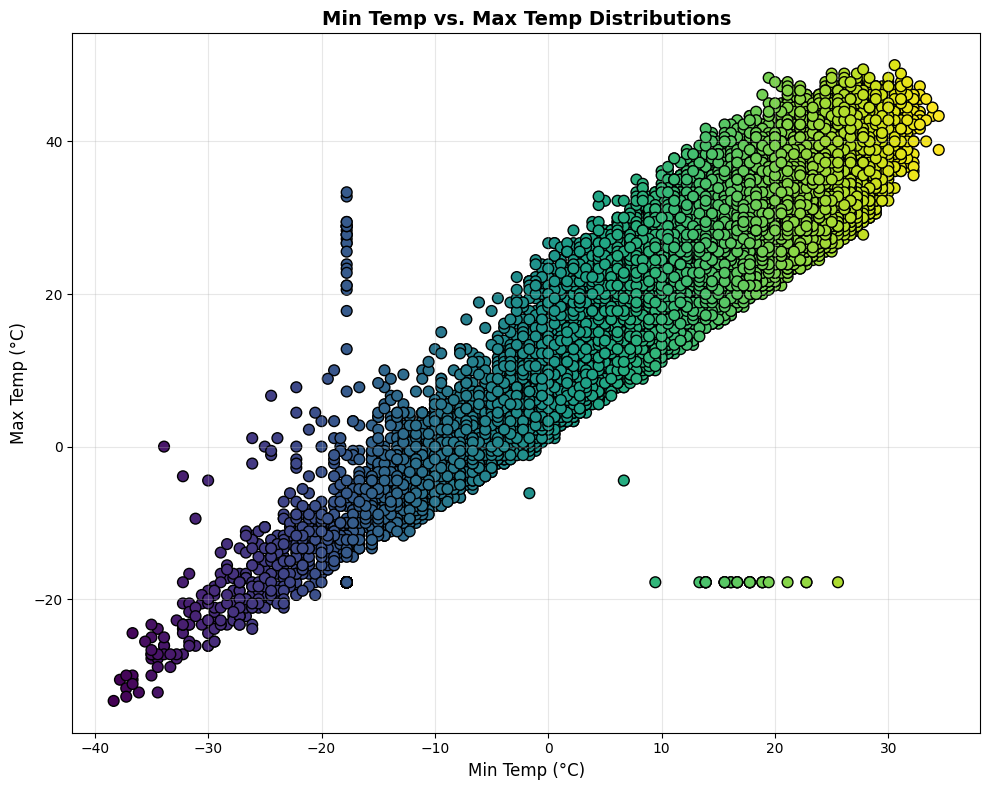

In [16]:
Plot_Distribution(df)


In [17]:
def Plot_Correlation(df):
    plt.figure(figsize = (6, 5))
    sns.heatmap(df.corr(), annot = True, cmap = "Oranges", fmt = ".3f")

    plt.title("Correlation Matrix", fontsize = 14, fontweight = "bold")
    plt.tight_layout()
    plt.show()
    

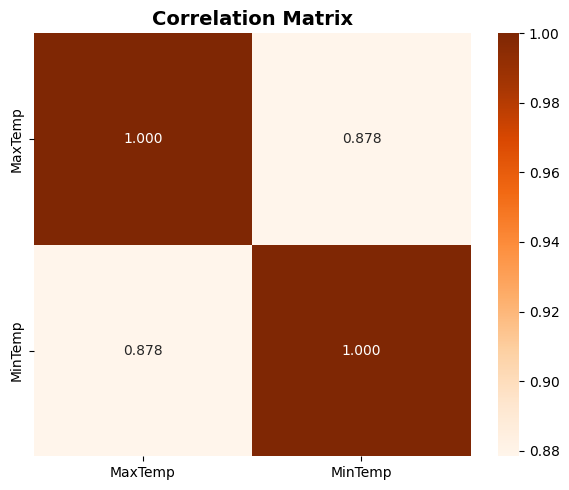

In [18]:
Plot_Correlation(df)


---

#### 总结 | Conclusion

1. The report above shows that both columns are highly left-skewed （左偏态分布） (as evidenced by the skewness（偏度） value and the comparison of the mean（均值） and median（中位数） values). In addition, the two columns above are leptokurtic（尖峰分布） (evidenced from the kurtosis（峰度） value, which is more than 3)
2. In the histogram distribution of both columns, it can be seen that there are long tails（长尾） (outliers, 异常值) visible on the left side.
3. The standard deviation（标准差） values for the two columns are smaller than the mean, so it can be concluded that the two columns lack variation.
4. When the two columns are compared, the MinTemp minimum value is lower (cooler) than the MaxTemp. On the other hand, the MaxTemp column"s maximum value is higher (hotter) than MinTemp"s.
5. The scatter plot clearly shows heterocedasticity（异方差性）, since the Min Temp values increases, the Max Temp also increases until form a cone shape（锥形）. In addition, the heatmap shows that there is significant correlation between Min Temp and Max Temp column.

> 术语解释

1. 左偏态（Left-skewed / Negatively skewed）
   - 数据分布的左侧（低值端）有较长的尾部，即少数极端小值拉低了分布的左侧。
   - 表示大多数数据集中在右侧（高值区），均值 < 中位数 < 众数。
2. 尖峰分布（Leptokurtic）
   - 峰度大于3的数据分布，峰形更尖锐，尾部更厚。
   - 与正态分布（峰度=3）相比，尖峰分布意味着数据在中心更集中，同时极端值（异常值）出现的概率更高。
3. 异方差性（Heteroscedasticity）
   - 误差项或数据的方差随自变量变化而变化，不恒定。
   - 在回归分析中，异方差性违反了经典线性回归的假设，可能导致参数估计不准确。


---

### 数据预处理 | Data Preprocessing

80:20 —— 80% training & 20% testing

- MaxTemp —— dependent variable
- MinTemp —— independent variable

---

In [19]:
X = df["MinTemp"].values.reshape(-1, 1)
y = df["MaxTemp"].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)


In [20]:
def Plot_DataSet_Split(X_train, X_test, y_train, y_test):
    plt.figure(figsize = (8, 6))
    plt.scatter(X_train, y_train, label = "Training Data", color = "blue", alpha = 0.5, edgecolor = "#303035")
    plt.scatter(X_test, y_test, label = "Testing Data", color = "red", alpha = 0.5, edgecolor = "#303035")

    plt.title("Train-Test Split", fontsize = 14, fontweight = "bold")
    plt.xlabel("Min Temp (°C)", fontsize = 12)
    plt.ylabel("Max Temp (°C)", fontsize = 12)

    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.tight_layout()
    plt.show()


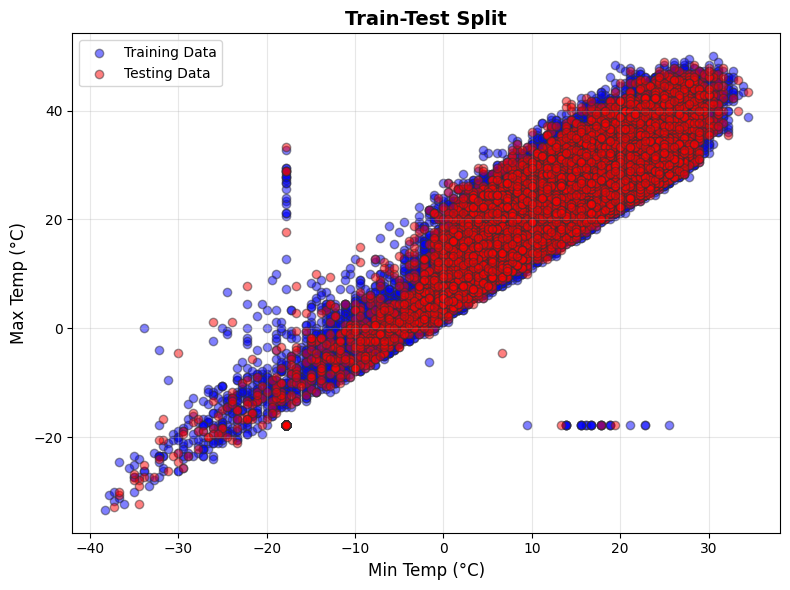

In [21]:
Plot_DataSet_Split(X_train, X_test, y_train, y_test)


---

### 线性回归 | Linear Regreesion

$$y = c_0 + c_1x$$


假设 | Assumption

1. Linearity
   - The dependent variable $y$ should have a linear relationship with the independent variables. A scatter plot between the two variables will help to assure this assumption.
2. Normality
   - Both the $x$ and $y$ variables should to follow a normal distribution.
3. Homoscedasticity
   - The spread of the residuals, or the variance of the error terms, ought to be constant for all values of $x$.
4. Independence/No Multicollinearity
   - There should be no connection between the variables, which means that they should be independent of one another.
5. The error terms should be normally distributed
6. No Autocorrelation
   - It is recommended that the error terms remain independent. Using the Durbin-Watson test, autocorrelation can be evaluated.

评估指标 | Evaluation Metrics

1. R Squared or Coefficient of Determination 
   - Interpreted as how well the regression model explains observed data
2. Mean Absolute Error (MAE) 
   - Lower values indicates better model
3. Mean Squared Error (MSE) 
   - Better model is indicated by lower values
4. Root Mean Squared Error (RMSE) 
   - Lower values indicates better model.

---

$$\left[ R^2 = 1 - \frac{\text{模型没解释的误差}}{\text{原始总误差}} \right] \in [0,1]$$

模型没解释的误差 - $\sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2$

原始总误差 - $\sum_{i=1}^{n} \left( y_i - \overline{y} \right)^2$

> 一般接近 1，0.8 ~ 0.9，模型解释了大部分变异，拟合效果很好。

- 说法：
  - **模型解释了多少比例的因变量（y）的波动？**
  - **模型解释了目标变量（y）约 x% 的波动或变异性。**
  - **模型成功捕捉到了数据中 x% 的规律或趋势，**

---

In [22]:
def train_linear_regression(
    X_train, y_train, X_test, y_test, 
    n_splits = 10, test_size = 0.2, random_state = 42
):
    """
    ShuffleSplit：
        一种交叉验证策略，它会随机打乱数据，然后按指定比例（test_size）划分训练集和测试集，重复 n_splits 次。
    LR：
        未训练模型
    model：
        已训练模型
    cv_scores：
        一个包含 10 个 R² 得分的数组，反映模型在训练集上的稳定性。
    n_jobs = -1：
        使用所有 CPU 核心并行计算，加快速度。
    """
    cv = ShuffleSplit(
        n_splits = n_splits, test_size = test_size, random_state = random_state
    )
    LR = LinearRegression()
    model = LR.fit(X_train, y_train)

    cv_scores = cross_val_score(
        LR, X_train, y_train, cv = cv, n_jobs = -1
    )

    y_pred = model.predict(X_test)

    return model, cv_scores, y_pred


In [23]:
model, cv_scores, y_pred = train_linear_regression(X_train, y_train, X_test, y_test)


In [24]:
def Print_Evaluation_Results(model, cv_scores, y_pred):
    
    print("==================== CROSS VALIDATION RESULTS ====================")
    print(f"Average Score: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}")
    
    print("\n==================== EVALUATION METRICS ====================")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):6f}")
    print(f"R²: {r2_score(y_test, y_pred):.6f}")
    
    print("\n==================== MODEL PARAMETERS ====================")
    print(f"Intercept (b0): {np.round(model.intercept_, 4)}")
    print(f"Coefficient (b1): {np.round(model.coef_[0], 4)}")


In [25]:
Print_Evaluation_Results(model, cv_scores, y_pred)


==================== CROSS VALIDATION RESULTS ====================
Average Score: 0.7718
Standard Deviation: 0.0043

==================== EVALUATION METRICS ====================
MAE: 3.177483
MSE: 17.115311
RMSE: 4.137065
R²: 0.772155

==================== MODEL PARAMETERS ====================
Intercept (b0): [10.6884]
Coefficient (b1): [0.9189]


---

#### 总结 | Conclusion

1. From the results of the average CV score, it can be said that the **model"s performance is good.** In addition, from CV standard deviation value, it can be concluded that **the model has very minimum variance** between each CV scores.
2. From evaluation metrics score, it can be seen that RMSE and MAE value is close to 0. In addition, the R squared value also reveals that 77% of the variability observed in the target variable is explained by the regression model. Based on those results, it can be concluded that **the model has good performance.**
3. Based on the intercept and coefficients result, the **linear regression formula** will be: $$y = 10.6884 + 0.9189x$$
    with
    - $x = $ independent variable (MinTemp)
    - $y = $ dependent variable (MaxTemp)

---

In [26]:
def Plot_Regression_Result(X_test, y_test, y_pred, model):
    
    plt.figure(figsize = (8, 6))

    plt.scatter(X_test, y_test, alpha = 1, s = 100, color = "blue", edgecolors = "#303035", label = "Actual Data")
    plt.plot(X_test, y_pred, color = "red", linewidth = 2, label = f"Regression Line: y = {np.round(model.intercept_.item(), 2)} + {np.round(model.coef_[0].item(), 2)}x")
    
    plt.title("Linear Regression Results", fontsize = 14, fontweight = "bold")
    plt.xlabel("Min Temp (°C)", fontsize = 12)
    plt.ylabel("Max Temp (°C)", fontsize = 12)
    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.tight_layout()
    plt.show()


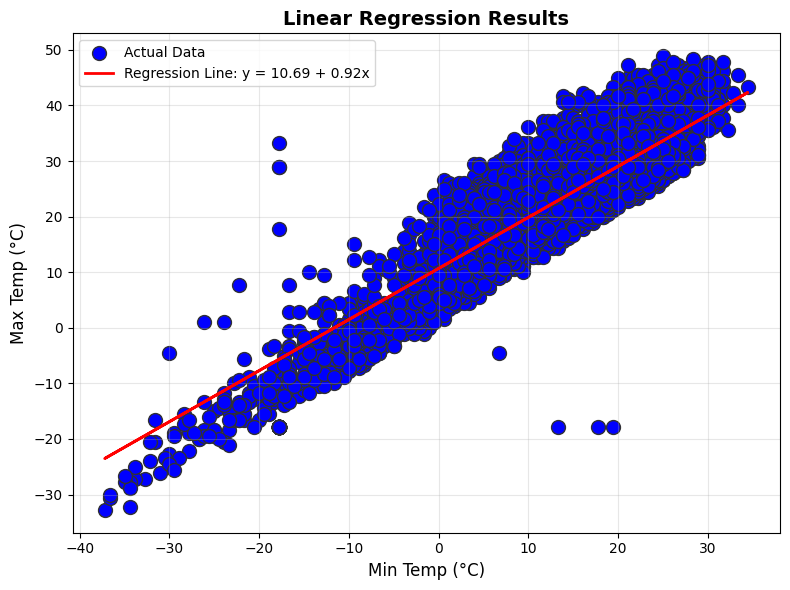

In [57]:
Plot_Regression_Result(X_test, y_test, y_pred, model)


In [79]:
def Plot_Prediction_Comparison(y_test, y_pred, sample_size = 6):
    
    comparison = pd.DataFrame({
        "Actual": y_test.flatten()[:sample_size],
        "Predicted": y_pred.flatten()[:sample_size]
    }, index = [f"Sample {i+1}" for i in range(sample_size)])
    
    df_comparison = comparison.reset_index().melt("index", var_name = "Type", value_name = "Temperature").rename(columns = {"index": "Sample"})
    
    plt.figure(figsize = (10, 6))
    sns.pointplot(
        data = df_comparison, 
        x = "Sample", 
        y = "Temperature", 
        hue = "Type", 
        palette = ["blue", "red"], 
        markers = ["o", "s"]
    )
    plt.title("Actual vs Predicted Temperature", fontsize = 14, fontweight = "bold")
    plt.xlabel("Sample", fontsize = 12)
    plt.ylabel("Temperature (°C)", fontsize = 12)
    
    plt.legend()
    plt.grid(True, alpha = 0.3)
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.show()
    
    return comparison.round(2)


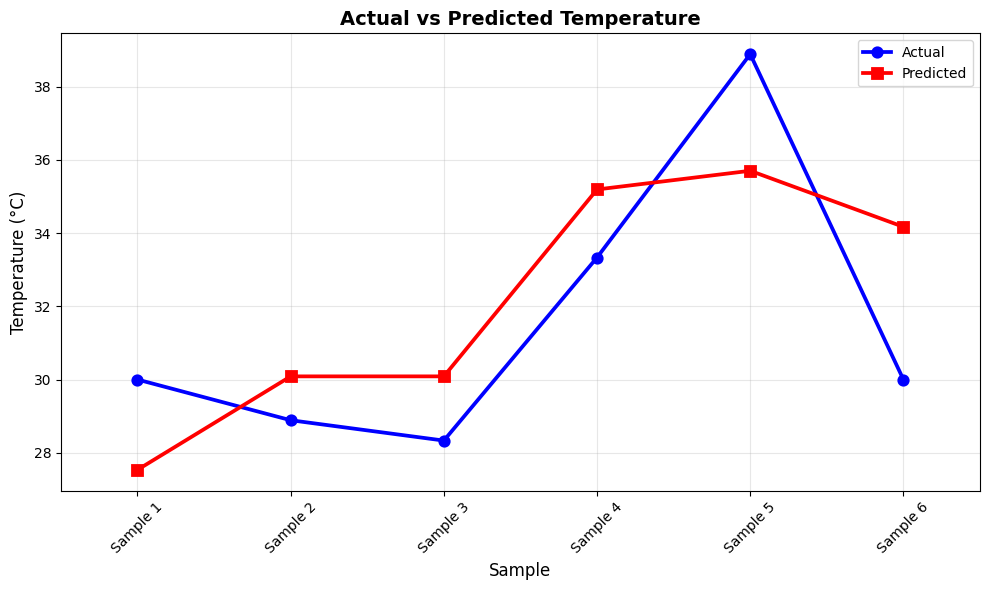

,Actual,Predicted
Sample 1,30.00,27.53
Sample 2,28.89,30.09
Sample 3,28.33,30.09
Sample 4,33.33,35.19
Sample 5,38.89,35.70
Sample 6,30.00,34.17


In [80]:
Plot_Prediction_Comparison(y_test, y_pred)
